# MixFlows with discretized Hamiltonian dynamics

This is a minimal working example of an implementation of Mixflows.

The target is a standard Gaussian $\pi(x)=\phi(x)$ 
and the reference $q_0$ is a $\mathcal{N}(2,0.3^2)$ distribution.
I am using a depth of $N=50$ to define $q_N$.
For the Hamiltonian dynamics, 
I am running $L=50$ steps of the leapfrog integrator
with a step size of $\epsilon=0.1$.

I am able to sample from $q_N$ and get something almost equal to the target $\pi$.
The problem is when trying to evaluate the density, which gives weird results.
Specifically, I want to estimate $q_N(x)$ for a grid of $1,000$ values
$x_i\in(-4,4), i=1,\dots,1,000$
(the high density region of $\pi$).

I am evaluating $q_N(x_i,\rho_0,u_0), i=1,\dots,1,000$
where $\rho_0,u_0$ are pseudo-random Laplace and uniform numbers
(but fixed for all $i$, i.e., I only generate one Laplace and one uniform
and then use those for all $x_i$).

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [2]:
"""
########################################
########################################
variational approximation functions
########################################
########################################
"""

def lqN(x,rho,u,N,lq0,L,epsilon,grad_lp,xi=np.pi/16,burnin=0):
    """
    evaluate variational log likelihood log qN(x,rho,u)
    x is M-dimensional but this implementation allows vectorizing over d input points
    
    inputs:
        x         : (M,d) array, positions (M=dim of x, d=number of input points)
        rho       : (M,d) array, momenta
        u         : (d,)  array, pseudo times (one for each point)
        N         : int, variational parameter; max number of applications of T
        lq0       : function, reference log likelihood (vectorized)
        L         : int, number of leapfrog steps for Hamiltonian dynamics
        epsilon   : float, step size for Hamiltonian dynamics
        grad_lp   : function, target score function for Hamiltonian dynamics (vectorized)
        xi        : scalar, pseudo time shift
        burnin    : int, number of samples to burn-in at first
        
     outputs:
         logqN(x,rho,u) : (d,) array, likelihood at each point (x_i,rho_i,u_i), i=1,...,d
    """
    # save copies to prevent changing input arrays
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    
    # define laplacian momentum fns
    lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm
    
    if N==1: return lq0(x_,rho_,u_) # no steps taken here
    
    # init weights and log jacobians
    w=np.zeros((N,x_.shape[1]))
    w[0,:]=lq0(x_,rho_,u_)
    lJ=np.zeros(x_.shape[1])
    
    # iterate through flow
    for n in range(N-1):
        x_,rho_,u_,tlJ=flow(1,x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,'bwd') # one step bwd
        lJ=lJ+tlJ # update log jacobian
        w[n+1,:]=lq0(x_,rho_,u_)+lJ # update weight
    # end for
    #return LogSumExp(w)-np.log(N)
    return LogSumExp(w[burnin:,:])-np.log(N-burnin)


def randqN(size,N,randq0,L,epsilon,grad_lp,xi=np.pi/16):
    """
    generate samples from the variational distribution qN
    
    inputs:
        size      : int, number of samples to generate
        N         : int, variational parameter; max number of applications of T
        randq0    : function, reference distribution sampler
        L         : int, number of leapfrog steps for Hamiltonian dynamics
        epsilon   : float, step size for Hamiltonian dynamics
        grad_lp   : function, target score function for Hamiltonian dynamics (vectorized)
        xi        : scalar, pseudo time shift
        
     outputs:
        rx      : (M,size) array, position samples
        rrho    : (M,size) array, momentum samples
        ru      : (size,) array, pseudo time samples
    """
    
    if N==1: return randq0(size)                     # sample from reference directly
    
    K=np.random.randint(low=0,high=N,size=size)      # generate number of steps per sample point
    lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm # laplacian momentum
    x,rho,u=randq0(size)                             # initialize samples
    for n in range(N):
        # update points where the current n does not exceed their corresponding K
        tx,trho,tu,_=flow(1,x[:,K>=n+1],rho[:,K>=n+1],u[K>=n+1],L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,'fwd')
        
        # save updates
        x[:,K>=n+1]=tx
        rho[:,K>=n+1]=trho
        u[K>=n+1]=tu
    # end for
    return x,rho,u
    

"""
########################################
########################################
flow functions
########################################
########################################
"""

def flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction):
    """
    compute T^n(x,rho,u)
    
    inputs:
        steps     : int, number of applications of T, n
        x         : (M,d) array, positions (M=dim of x, d=number of input points)
        rho       : (M,d) array, momenta
        u         : (d,)  array, pseudo times (one for each point)
        L         : int, number of leapfrog steps for Hamiltonian dynamics
        epsilon   : float, step size for Hamiltonian dynamics
        grad_lp   : function, target score function for Hamiltonian dynamics (vectorized)
        lm,Fm,Qm,grad_lm : functions, momentum log density, cdf, quantile fn, and score fn (respectively)
        xi        : scalar, pseudo time shift
        direction : string, one of 'fwd' (forward map) or 'bwd' (backward map)
        
     outputs:
       x'   : (M,d) array, updated positions
       rho' : (M,d) array, updated momenta
       u'   : (M,d) array, updated pseudo times
       ljs  : (d,)  array, log Jacobians for each sample point
    """
    # save copies to prevent changing input arrays
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    
    # initialize log jacobians and return input if no steps
    lJ=np.zeros(x_.shape[1])
    if steps==0: return x_,rho_,u_,lJ
    
    # iterate flow
    for n in range(steps):
        # take a step and update log jacobian
        if direction=='fwd': x_,rho_,u_,tmplJ=forward( x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        if direction=='bwd': x_,rho_,u_,tmplJ=backward(x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        lJ=lJ+tmplJ
    # end for
    return x_,rho_,u_,lJ


def forward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    """
    compute T(x,rho,u) (i.e., one step forward)
    
    inputs:
        x         : (M,d) array, positions (M=dim of x, d=number of input points)
        rho       : (M,d) array, momenta
        u         : (d,)  array, pseudo times (one for each point)
        L         : int, number of leapfrog steps for Hamiltonian dynamics
        epsilon   : float, step size for Hamiltonian dynamics
        grad_lp   : function, target score function for Hamiltonian dynamics (vectorized)
        lm,Fm,Qm,grad_lm : functions, momentum log density, cdf, quantile fn, and score fn (respectively)
        xi        : scalar, pseudo time shift
        
     outputs:
       x'   : (M,d) array, updated positions
       rho' : (M,d) array, updated momenta
       u'   : (M,d) array, updated pseudo times
       ljs  : (d,)  array, log Jacobians for each sample point
    """
    x_,rho_=Ham(x,rho,L,epsilon,grad_lp,grad_lm) # run Hamiltonian dynamics
    lJ=lm(rho_)                                  # compute momentum log density
    u_=(u+xi)%1                                  # update pseudo time
    rho_=Qm((Fm(rho_)+pseudo_random(x_,u_))%1)   # refresh momentum
    lJ=lJ-lm(rho_)                               # compute new momentum log density for log Jacobian
    return x_,rho_,u_,lJ


def backward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    """
    compute T^{-1}(x,rho,u) (i.e., one step backward)
    
    inputs:
        x         : (M,d) array, positions (M=dim of x, d=number of input points)
        rho       : (M,d) array, momenta
        u         : (d,)  array, pseudo times (one for each point)
        L         : int, number of leapfrog steps for Hamiltonian dynamics
        epsilon   : float, step size for Hamiltonian dynamics
        grad_lp   : function, target score function for Hamiltonian dynamics (vectorized)
        lm,Fm,Qm,grad_lm : functions, momentum log density, cdf, quantile fn, and score fn (respectively)
        xi        : scalar, pseudo time shift
        
     outputs:
       x'   : (M,d) array, updated positions
       rho' : (M,d) array, updated momenta
       u'   : (M,d) array, updated pseudo times
       ljs  : (d,)  array, log Jacobians for each sample point
    """
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)    # save copies to prevent changing input arrays
    lJ=lm(rho_)                                      # compute momentum log density
    rho_=Qm((Fm(rho_)-pseudo_random(x_,u_))%1)       # inverse momentum refreshment
    lJ=lJ-lm(rho_)                                   # compute new momentum log density for log Jacobian
    u_=(1.+u_-xi)%1                                  # inverse pseudo time shift
    x_,rho_=Ham(x_,rho_,L,-epsilon,grad_lp,grad_lm)  # run Hamiltonian dynamics backwards (with -eps)
    return x_,rho_,u_,lJ


def Ham(x,rho,L,epsilon,grad_lp,grad_lm):
    """
    simulate Hamiltonian dynamics via leapfrog integration
    
    inputs:
        x         : (M,d) array, positions (M=dim of x, d=number of input points)
        rho       : (M,d) array, momenta
        L         : int, number of leapfrog steps for Hamiltonian dynamics
        epsilon   : float, step size for Hamiltonian dynamics
        grad_lp   : function, target score function for Hamiltonian dynamics (vectorized)
        grad_lm   : function, momentum score function
        
     outputs:
       x'   : (M,d) array, updated positions
       rho' : (M,d) array, updated momenta
    """
    x_,rho_=np.copy(x),np.copy(rho) # save copies to prevent changing input arrays
    for l in range(L): # simulate dynamics for L steps
        rhot = rho_  + epsilon*grad_lp(x_)/2  # momentum half step
        x_    = x_   - epsilon*grad_lm(rhot)  # position full step
        rho_  = rhot + epsilon*grad_lp(x_)/2  # momentum half step
    # end for
    return x_,rho_


"""
########################################
########################################
momentum functions
########################################
########################################
"""
def lap_lm(rho):     return -np.sum(np.abs(rho),axis=0)-rho.shape[0]*np.log(2.) #(M,d)->(d,)
def lap_Fm(rho):     return 0.5-0.5*np.sign(rho)*np.expm1(-np.abs(rho))         #(M,d)->(M,d)
def lap_Qm(p)  :     return np.sign(0.5-p)*np.log1p(-2.*np.abs(p-0.5))          #(M,d)->(M,d)
def lap_gradlm(rho): return -np.sign(rho)                                       #(M,d)->(M,d)


"""
########################################
########################################
auxiliary functions
########################################
########################################
"""
def LogSumExp(w):
    """
    LogSumExp trick

    inputs:
        w : (M,d) array, exponents

    outputs:
        w' : (d,) array, log(sum(exp(w)))
    """

    wmax = np.amax(w,axis=0)
    return wmax + np.log(np.sum(np.exp(w-wmax[np.newaxis,:]),axis=0))


def pseudo_random(x,u): return 0.5*np.sin(2*x+u)+0.5 # used for pseudo time update

# define generic 1d gaussian log density
def gauss_lp(x,mu,sigma): return -0.5*np.sum((x-mu)**2,axis=0)/sigma**2-x.shape[0]*np.log(2*np.pi*sigma**2)/2

In [27]:
"""
########################################
########################################
simulation settings
########################################
########################################
"""

# target specification
p_mu = 2.
p_sd = np.sqrt(2.)
def lp(x): return gauss_lp(x,p_mu,p_sd)  # Gaussian
def grad_lp(x): return -(x-p_mu)/p_sd**2 # Gaussian score

# reference specification
mu0=0
sigma0=1.
def lq0(x,rho,u): return gauss_lp(x,mu0,sigma0)+lap_lm(rho) # N(mu0,sigma0^2) for position + laplace momentum
def randq0(size): return mu0+sigma0*np.random.randn(1,size),np.random.laplace(size=(1,size)),np.random.rand(size)

# flow settings
N=200
L=50
epsilon=0.05
xi=np.pi/16

## Sampling works okay

In [4]:
size=10000 # number of samples to generate
x,rho,u=randqN(size,N,randq0,L,epsilon,grad_lp,xi)

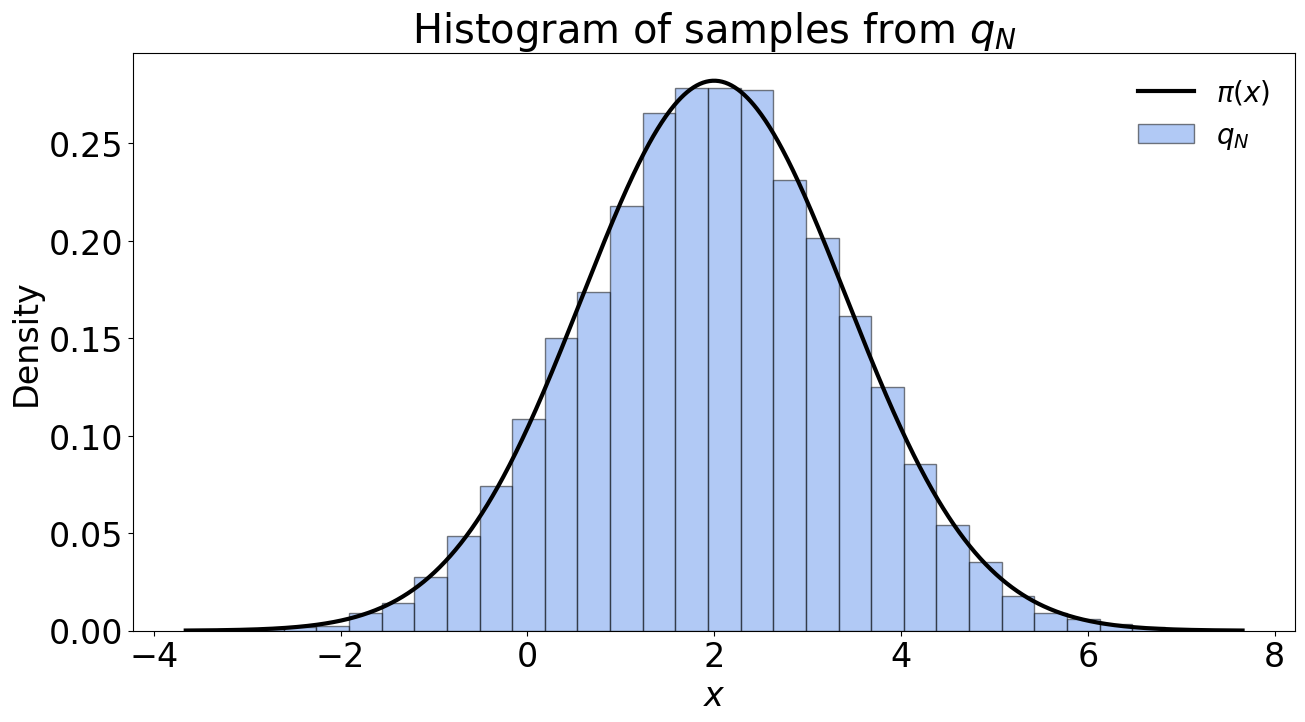

In [5]:
lsx=np.linspace(p_mu-4*p_sd,p_mu+4*p_sd,1000)
plt.plot(lsx,np.exp(lp(lsx[np.newaxis,:])),c='black',lw=3,label=r'$\pi(x)$')
plt.hist(x[0,:],bins=30,density=True,ec='black',alpha=0.5,label=r'$q_N$',color='cornflowerblue')
plt.xlabel(r'$x$')
plt.ylabel('Density')
plt.title(r'Histogram of samples from $q_N$')
plt.legend(fontsize='small',frameon=False)

## But density evaluation does not

In [42]:
x = np.linspace(p_mu-4*p_sd,p_mu+4*p_sd,1000)[np.newaxis,:]   # calculate the density at grid of values of position in (-4,4)
rho = 0*np.random.laplace()*np.ones(x.shape) # for momentum, choose just one value to get a slice of qN(x,rho,u)
u = 0.5*np.random.rand()*np.ones(x.shape[1])   # ditto for pseudo time
burnin = 2

In [43]:
lqs=np.zeros(x.shape[-1])
#for i in range(x.shape[-1]):
#    lqs[i]=lqN(x[:,i].reshape(1,1),np.zeros((1,1)),np.array([0.5]),N,lq0,L,epsilon,grad_lp,xi=np.pi/16,burnin=burnin)

In [44]:
lq=lqN(x,rho,u,N,lq0,L,epsilon,grad_lp,xi=np.pi/16,burnin=burnin)

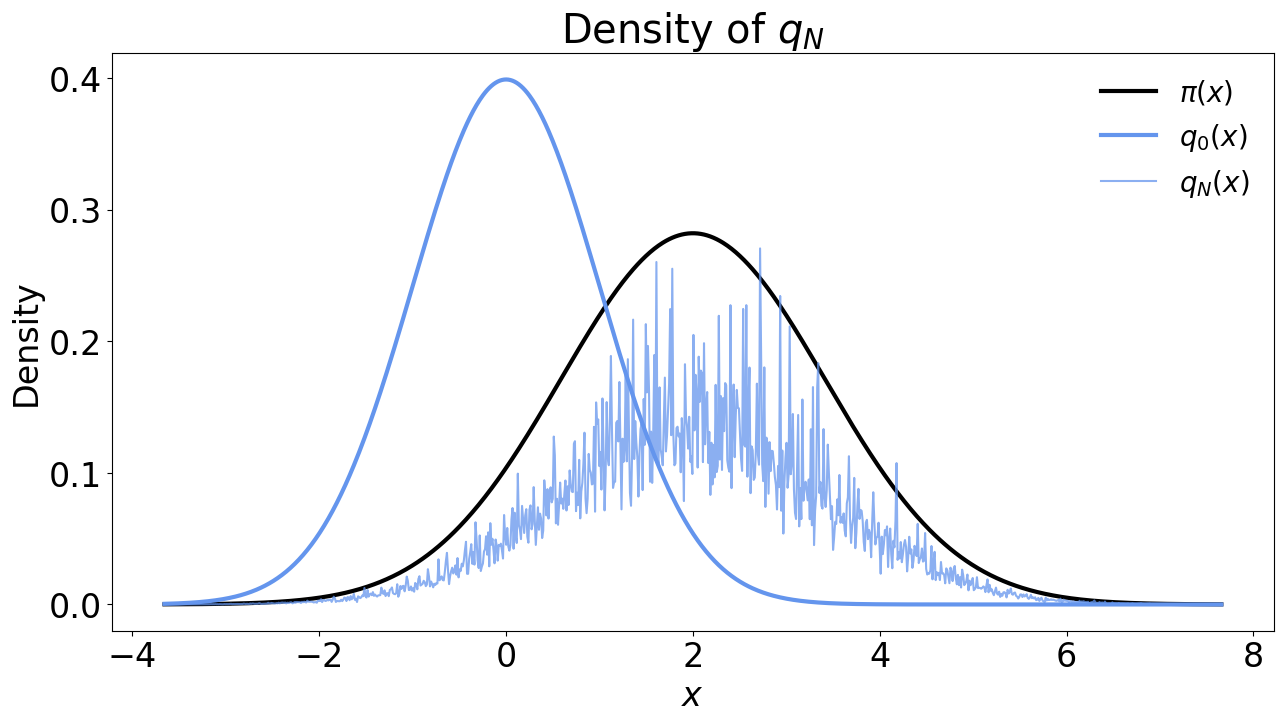

In [45]:
plt.plot(x[0,:],np.exp(lp(x)),c='black',lw=3,label=r'$\pi(x)$')
plt.plot(x[0,:],np.exp(gauss_lp(x,mu0,sigma0)),c='cornflowerblue',lw=3,label=r'$q_0(x)$')
plt.plot(x[0,:],np.exp(lq),color='cornflowerblue', label=r'$q_N(x)$',alpha=0.75)
plt.xlabel(r'$x$')
plt.ylabel('Density')
plt.title(r'Density of $q_N$')
plt.legend(fontsize='small',frameon=False)

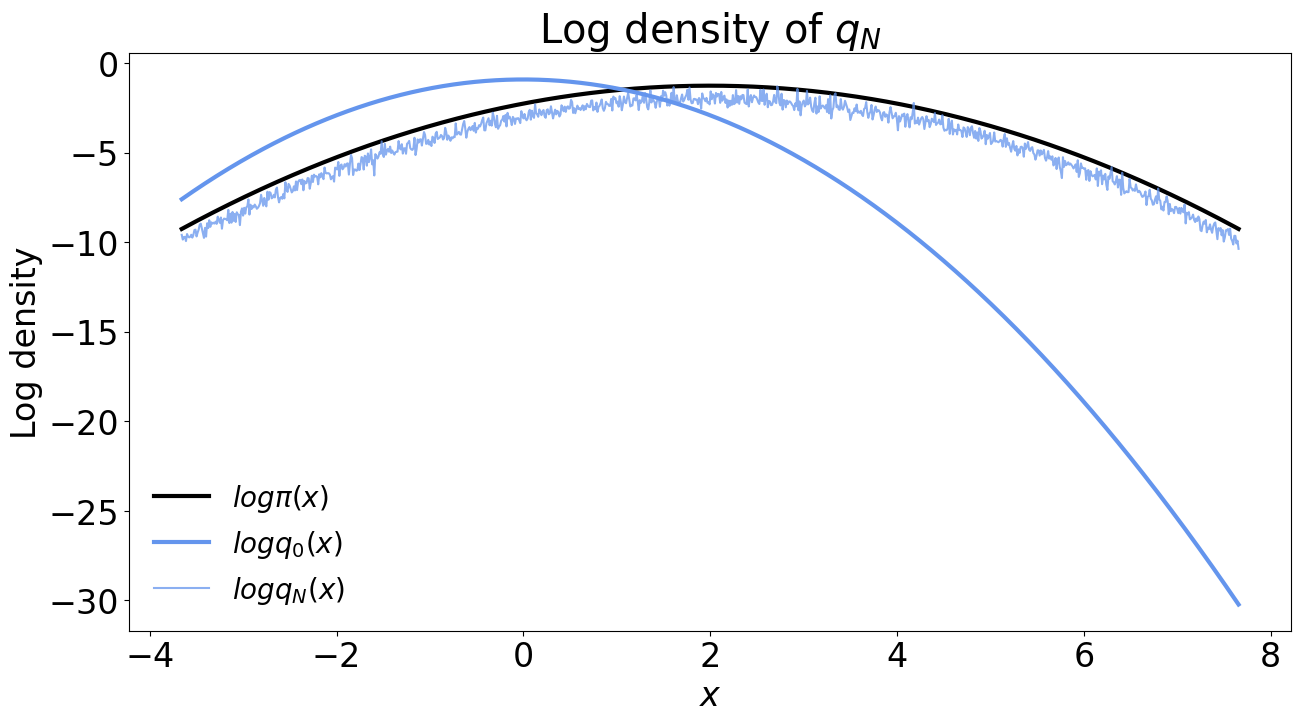

In [46]:
plt.plot(x[0,:],lp(x),c='black',lw=3,label=r'$log \pi(x)$')
plt.plot(x[0,:],gauss_lp(x,mu0,sigma0),c='cornflowerblue',lw=3,label=r'$log q_0(x)$')
plt.plot(x[0,:],lq,color='cornflowerblue', label=r'$log q_N(x)$',alpha=0.75)
plt.xlabel(r'$x$')
plt.ylabel('Log density')
plt.title(r'Log density of $q_N$')
plt.legend(fontsize='small',frameon=False)

## What I would have expected to see:

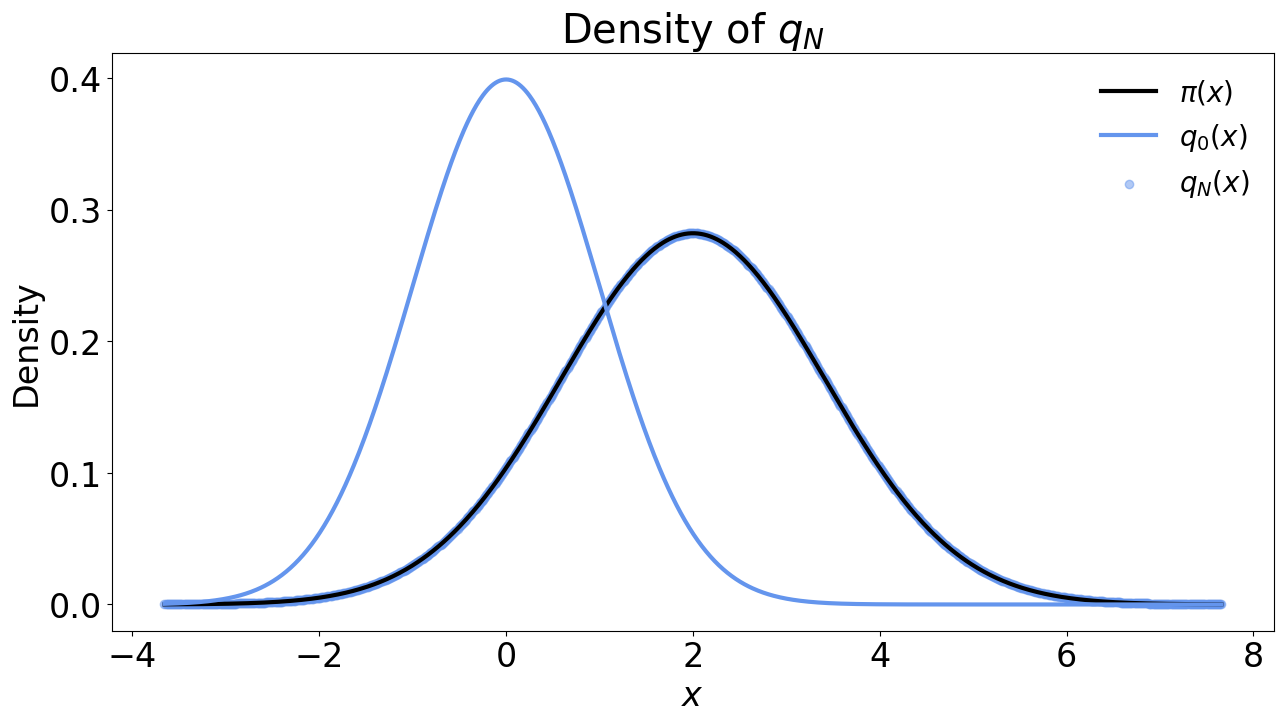

In [11]:
plt.plot(x[0,:],np.exp(lp(x)),c='black',lw=3,label=r'$\pi(x)$')
plt.plot(x[0,:],np.exp(gauss_lp(x,mu0,sigma0)),c='cornflowerblue',lw=3,label=r'$q_0(x)$')
plt.scatter(x[0,:],np.exp(lp(x)),color='cornflowerblue', label=r'$q_N(x)$',alpha=0.5)
plt.xlabel(r'$x$')
plt.ylabel('Density')
plt.title(r'Density of $q_N$')
plt.legend(fontsize='small',frameon=False)